# 問題 "quercetin"PM7を用いて計算し(キーワードはwinmostarのデフォルトのまま使用して、HamiltonianをPM7に変更する)、HOMOの値を示せ。

-8.688 ev

# 問題2 "PubChem_TCI_records.sdf"の中にある分子のうち後ろから10個を選んでMOPAC2016で計算し、HOMOとLUMOの差が最も小さい分子を表示せよ。

In [1]:
import os
import glob

import pandas as pd
from tqdm.notebook import tqdm

from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools, MolStandardize

In [2]:
folder_name = "homework/"

In [3]:
df = PandasTools.LoadSDF('PubChem_compound_list_antioxidant.sdf')

In [4]:
mols = df["ROMol"]

In [5]:
mols_list = mols[-10:]

In [6]:
errorlist=[]
lfc = MolStandardize.fragment.LargestFragmentChooser()

for mol in tqdm(mols_list):
    try:
        #一番大きなフラグメントを選ぶ
        mol = lfc.choose(mol)
        #molファイルをsmilesにする
        smiles=Chem.MolToSmiles(mol)
        #初期化
        energy=[]
        #水素の付加
        mol = Chem.AddHs(mol)
        #3次元構造の生成
        AllChem.EmbedMolecule(mol)
        #
        cids = AllChem.EmbedMultipleConfs(mol, numConfs=1000, randomSeed=1234,
                                           pruneRmsThresh=2, numThreads=0)
        for cid in cids:
            prop = AllChem.MMFFGetMoleculeProperties(mol)
            mmff = AllChem.MMFFGetMoleculeForceField(mol, prop, confId=cid)
            mmff.Minimize()
            
            energy.append((mmff.CalcEnergy(), cid))

            energy.sort()
            conf = mol.GetConformer(energy[0][1])

            #ファイルを作成
            with open(folder_name + smiles+'.dat', 'w') as f: 
                print('PM7 EF PRECISE GNORM=0.05 NOINTER GRAPHF VECTORS MMOK', file=f)
                print(smiles, file=f)
                print('Good Luck!', file=f)
                for n,(x,y,z) in enumerate(conf.GetPositions()):
                    atom = mol.GetAtomWithIdx(n)
                    print('{}  {:.6f} 1 {:.6f} 1 {:.6f} 1'.format(atom.GetSymbol(),x,y,z), file=f)
           
    except:
        print(smiles)
        errorlist.append(smiles)

  0%|          | 0/10 [00:00<?, ?it/s]

CC(C)=CCC/C(C)=C/CC/C(C)=C/CCC1(C)CCc2cc(O)ccc2O1
N/C(=N\O)c1cc(O)c(O)c(O)c1


In [7]:
calc_dats = glob.glob(folder_name +"*.dat")

In [8]:
len(calc_dats)

7

In [9]:
for dat in tqdm(calc_dats):
    !"C:\program files\mopac\MOPAC2016.exe" $dat

  0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
files = glob.glob(folder_name +"*.arc")
files

['homework\\CC(=O)NC(CSSCC(N)C(=O)O)C(=O)O.arc',
 'homework\\CC(C)(C)c1cc(CN2CCN(CC(O)c3ccc(Cl)cc3)CC2)cc(C(C)(C)C)c1O.arc',
 'homework\\Cc1cc(O)c(C)c2c1OC(C)(CCCC(C)CCCC(C)CCCC(C)C)CC2.arc',
 'homework\\CN1C2CC(OC(=O)C(CO)c3ccccc3)CC1C(O)C2.arc',
 'homework\\O=C1OC(C(O)CO)C(O)=C1O.arc',
 'homework\\O=C1OC(C2COC(c3ccccc3)O2)C(O)=C1O.arc',
 'homework\\O=c1[nH]cnc2[nH]ncc12.arc']

In [11]:
names = []
Lists=[]

for file in files:
    List=[]
    name = os.path.splitext(os.path.basename(file))[0]
    names.append(name)
    print(name)
    with open(file) as f:
        # 読み込んだファイルをリストに入れている。
        lines = f.readlines()
        #stripメソッドで空白や特定文字の削除
        lines_strip = [line.strip() for line in lines]
        #特定の文字列があるかを判定
        HOMO_line = [line for line in lines_strip if 'HOMO' in line]
        LUMO_line = [line for line in lines_strip if 'LUMO' in line]
        #空でなかったら、特定の場所にある数字を加えている。
        if HOMO_line != []:
            HOMO=float(str(HOMO_line[0][30:39]))
            print(HOMO)      
        else:
            HOMO=10**9+7
            print("error")
        List.append(HOMO)
        
        if LUMO_line != []:
            LUMO=float(str(LUMO_line[0][42:49]))
            print(LUMO) 
        else:
            LUMO=10**9+7
        List.append(LUMO)
        
    Lists.append(List)

CC(=O)NC(CSSCC(N)C(=O)O)C(=O)O
-8.83
0.995
CC(C)(C)c1cc(CN2CCN(CC(O)c3ccc(Cl)cc3)CC2)cc(C(C)(C)C)c1O
-8.55
0.053
Cc1cc(O)c(C)c2c1OC(C)(CCCC(C)CCCC(C)CCCC(C)C)CC2
-8.09
0.363
CN1C2CC(OC(=O)C(CO)c3ccccc3)CC1C(O)C2
-9.05
0.122
O=C1OC(C(O)CO)C(O)=C1O
-9.47
0.559
O=C1OC(C2COC(c3ccccc3)O2)C(O)=C1O
-9.36
0.417
O=c1[nH]cnc2[nH]ncc12
-9.73
0.933


In [12]:
Lists

[[-8.83, 0.995],
 [-8.55, 0.053],
 [-8.09, 0.363],
 [-9.05, 0.122],
 [-9.47, 0.559],
 [-9.36, 0.417],
 [-9.73, 0.933]]

In [13]:
df_read = pd.DataFrame(Lists, index = names, columns=["HOMO", "LUMO"])
df_read

,HOMO,LUMO
CC(=O)NC(CSSCC(N)C(=O)O)C(=O)O,-8.83,0.995
CC(C)(C)c1cc(CN2CCN(CC(O)c3ccc(Cl)cc3)CC2)cc(C(C)(C)C)c1O,-8.55,0.053
Cc1cc(O)c(C)c2c1OC(C)(CCCC(C)CCCC(C)CCCC(C)C)CC2,-8.09,0.363
CN1C2CC(OC(=O)C(CO)c3ccccc3)CC1C(O)C2,-9.05,0.122
O=C1OC(C(O)CO)C(O)=C1O,-9.47,0.559
O=C1OC(C2COC(c3ccccc3)O2)C(O)=C1O,-9.36,0.417
O=c1[nH]cnc2[nH]ncc12,-9.73,0.933


In [14]:
df_read["HOMO-LUMOgap"] = df_read["LUMO"] - df_read["HOMO"]

In [15]:
df_read

,HOMO,LUMO,HOMO-LUMOgap
CC(=O)NC(CSSCC(N)C(=O)O)C(=O)O,-8.83,0.995,9.825
CC(C)(C)c1cc(CN2CCN(CC(O)c3ccc(Cl)cc3)CC2)cc(C(C)(C)C)c1O,-8.55,0.053,8.603
Cc1cc(O)c(C)c2c1OC(C)(CCCC(C)CCCC(C)CCCC(C)C)CC2,-8.09,0.363,8.453
CN1C2CC(OC(=O)C(CO)c3ccccc3)CC1C(O)C2,-9.05,0.122,9.172
O=C1OC(C(O)CO)C(O)=C1O,-9.47,0.559,10.029
O=C1OC(C2COC(c3ccccc3)O2)C(O)=C1O,-9.36,0.417,9.777
O=c1[nH]cnc2[nH]ncc12,-9.73,0.933,10.663


In [16]:
df_read.sort_values(by=["HOMO-LUMOgap"], ascending=True)

,HOMO,LUMO,HOMO-LUMOgap
Cc1cc(O)c(C)c2c1OC(C)(CCCC(C)CCCC(C)CCCC(C)C)CC2,-8.09,0.363,8.453
CC(C)(C)c1cc(CN2CCN(CC(O)c3ccc(Cl)cc3)CC2)cc(C(C)(C)C)c1O,-8.55,0.053,8.603
CN1C2CC(OC(=O)C(CO)c3ccccc3)CC1C(O)C2,-9.05,0.122,9.172
O=C1OC(C2COC(c3ccccc3)O2)C(O)=C1O,-9.36,0.417,9.777
CC(=O)NC(CSSCC(N)C(=O)O)C(=O)O,-8.83,0.995,9.825
O=C1OC(C(O)CO)C(O)=C1O,-9.47,0.559,10.029
O=c1[nH]cnc2[nH]ncc12,-9.73,0.933,10.663


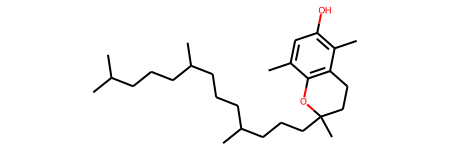

In [17]:
Chem.MolFromSmiles("Cc1cc(O)c(C)c2c1OC(C)(CCCC(C)CCCC(C)CCCC(C)C)CC2")